In [153]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import cv2


In [154]:
# ===============================
# Cell 2: Load paths and labels
# ===============================
data_dir = "./dataset"   
classes = ["normal", "osteoporosis"]

all_image_paths = []
all_labels = []
for idx, cls in enumerate(classes):
    paths = glob(os.path.join(data_dir, cls, "*"))
    all_image_paths.extend(paths)
    all_labels.extend([idx]*len(paths))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Total images:", len(all_image_paths))

Total images: 372


In [155]:
# Cell 3: Inspect dataset and collect filepaths & labels
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_index = {c:i for i,c in enumerate(classes)}
print("Classes:", classes)

filepaths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    files = sorted(glob(os.path.join(cls_dir, "*")))
    print(f"Found {len(files)} images in {cls}")
    for f in files:
        filepaths.append(os.path.abspath(f))
        labels.append(class_to_index[cls])

filepaths = np.array(filepaths)
labels = np.array(labels)
print("Total images:", len(filepaths))


Classes: ['normal', 'osteoporosis']
Found 186 images in normal
Found 186 images in osteoporosis
Total images: 372


In [156]:
# ===============================
# Cell 3: Split data
# ===============================
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, stratify=all_labels, test_size=0.3, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, stratify=temp_labels, test_size=0.5, random_state=42
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Train: 260, Val: 56, Test: 56


In [157]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [159]:
# =========================
# HELPER FUNCTIONS
# =========================

def safe_resize(img):
    """Resize safely with OpenCV."""
    try:
        img = cv2.resize(img, IMG_SIZE)
    except:
        img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    return img

def apply_clahe(img):
    """Apply CLAHE preprocessing."""
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(gray)
        img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
    except:
        img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    return img

def apply_denoise_clahe(img):
    """Apply denoising + CLAHE preprocessing."""
    try:
        img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(gray)
        img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)
    except:
        img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    return img

# =========================
# PIPELINE PREPROCESSORS
# =========================

# -----------------------------
# Pipeline 3: Normalization + CLAHE
# -----------------------------
def preprocess_3_img(path, label):
    def _process(path_str):
        img = cv2.imread(path_str.decode(), cv2.IMREAD_COLOR)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)  # fallback
        else:
            img = cv2.resize(img, (224, 224))
            img = apply_clahe(img)
        img = img.astype("float32") / 255.0
        return img
    img = tf.numpy_function(_process, [path], tf.float32)
    img = tf.ensure_shape(img, (224, 224, 3))   # ✅ important
    return img, label



# -----------------------------
# Pipeline 4: Normalization + Denoising + CLAHE
# -----------------------------
def preprocess_4_img(path, label):
    def _process(path_str):
        img = cv2.imread(path_str.decode(), cv2.IMREAD_COLOR)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            img = cv2.resize(img, (224, 224))
            img = apply_denoise_clahe(img)
        img = img.astype("float32") / 255.0
        return img
    img = tf.numpy_function(_process, [path], tf.float32)
    img = tf.ensure_shape(img, (224, 224, 3))
    return img, label


# -----------------------------
# Pipeline 5: Normalization + CLAHE + Data Augmentation
# -----------------------------
def preprocess_5_img(path, label):
    def _process(path_str):
        img = cv2.imread(path_str.decode(), cv2.IMREAD_COLOR)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            img = cv2.resize(img, (224, 224))
            img = apply_clahe(img)
        img = img.astype("float32") / 255.0
        return img
    img = tf.numpy_function(_process, [path], tf.float32)
    img = tf.ensure_shape(img, (224, 224, 3))

    # ✅ Safe TF augmentations (inside graph)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)

    return img, label


In [160]:
# --- Pipeline 3 ---
train_ds_3 = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .map(preprocess_3_img, num_parallel_calls=AUTOTUNE)
    .shuffle(256).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

val_ds_3 = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(preprocess_3_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

test_ds_3 = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(preprocess_3_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

# --- Pipeline 4 ---
train_ds_4 = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .map(preprocess_4_img, num_parallel_calls=AUTOTUNE)
    .shuffle(256).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

val_ds_4 = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(preprocess_4_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

test_ds_4 = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(preprocess_4_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

# --- Pipeline 5 ---
train_ds_5 = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .map(preprocess_5_img, num_parallel_calls=AUTOTUNE)
    .shuffle(256).batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

val_ds_5 = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(preprocess_5_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)

test_ds_5 = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(preprocess_5_img, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE).prefetch(AUTOTUNE)
)


In [161]:
# Model
base_model_3 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_3.trainable = False

model_3 = tf.keras.Sequential([
    base_model_3,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_3.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [162]:
print("\nTraining PIPELINE 1 (Raw Images)...\n")
history_3 = model_3.fit(train_ds_3, validation_data=val_ds_3, epochs=10)


Training PIPELINE 1 (Raw Images)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 707ms/step - accuracy: 0.5000 - loss: 0.7966 - val_accuracy: 0.5179 - val_loss: 0.7082
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 530ms/step - accuracy: 0.4923 - loss: 0.7843 - val_accuracy: 0.5179 - val_loss: 0.6752
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.4962 - loss: 0.7775 - val_accuracy: 0.5893 - val_loss: 0.6524
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 507ms/step - accuracy: 0.6038 - loss: 0.7278 - val_accuracy: 0.6071 - val_loss: 0.6327
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 613ms/step - accuracy: 0.5154 - loss: 0.7609 - val_accuracy: 0.6607 - val_loss: 0.6137
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 613ms/step - accuracy: 0.5692 - loss: 0.7195 - val_accuracy: 0.6964 - val_loss: 0.5961
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 511ms/step - accuracy: 0.5731 - loss: 0.7219 - val_accuracy: 0.7321 - val_loss: 0.5822
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 550ms/step - accu

In [165]:
# Model
base_model_4 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_4.trainable = False

model_4 = tf.keras.Sequential([
    base_model_4,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_4.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_4.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [166]:
print("\nTraining PIPELINE 4 (Raw Images)...\n")
history_4 = model_4.fit(train_ds_4, validation_data=val_ds_4, epochs=10)


Training PIPELINE 4 (Raw Images)...

Epoch 1/10


17/17 ━━━━━━━━━━━━━━━━━━━━ 42s 894ms/step - accuracy: 0.5038 - loss: 0.8053 - val_accuracy: 0.5179 - val_loss: 0.7255
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 765ms/step - accuracy: 0.4769 - loss: 0.8089 - val_accuracy: 0.5536 - val_loss: 0.6855
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 719ms/step - accuracy: 0.5346 - loss: 0.7519 - val_accuracy: 0.5893 - val_loss: 0.6623
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 906ms/step - accuracy: 0.5654 - loss: 0.7175 - val_accuracy: 0.6250 - val_loss: 0.6416
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 736ms/step - accuracy: 0.5654 - loss: 0.6842 - val_accuracy: 0.6429 - val_loss: 0.6238
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 702ms/step - accuracy: 0.6000 - loss: 0.7113 - val_accuracy: 0.6964 - val_loss: 0.6074
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 703ms/step - accuracy: 0.5885 - loss: 0.6916 - val_accuracy: 0.6786 - val_loss: 0.5946
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 727ms/step - accuracy: 0.5731 - loss: 0.7081 - val_accuracy: 0.714

In [167]:
# Model
base_model_5 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_5.trainable = False

model_5 = tf.keras.Sequential([
    base_model_5,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_5.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_5.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [168]:
print("\nTraining PIPELINE 1 (Raw Images)...\n")
history_5 = model_5.fit(train_ds_5, validation_data=val_ds_5, epochs=10)


Training PIPELINE 1 (Raw Images)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 681ms/step - accuracy: 0.4615 - loss: 0.9248 - val_accuracy: 0.3929 - val_loss: 0.8461
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 589ms/step - accuracy: 0.4808 - loss: 0.8774 - val_accuracy: 0.5536 - val_loss: 0.7867
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 527ms/step - accuracy: 0.5115 - loss: 0.8302 - val_accuracy: 0.6071 - val_loss: 0.7594
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 525ms/step - accuracy: 0.5269 - loss: 0.7811 - val_accuracy: 0.6071 - val_loss: 0.7206
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 535ms/step - accuracy: 0.5654 - loss: 0.7410 - val_accuracy: 0.6071 - val_loss: 0.6927
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5423 - loss: 0.7354 - val_accuracy: 0.6786 - val_loss: 0.6724
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 828ms/step - accuracy: 0.5769 - loss: 0.6865 - val_accuracy: 0.6607 - val_loss: 0.6327
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 543ms/step - accurac

In [169]:
# ==============================================================
# 📌 Evaluation Helper
# ==============================================================

def evaluate_and_report(model, dataset, split_name="Validation"):
    y_true, y_pred = [], []
    for imgs, lbls in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(lbls.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())

    print(f"\n{split_name} -> Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


EVALUATION: PIPELINE 3 (Raw Images)

Validation -> Accuracy: 0.5178571428571429
              precision    recall  f1-score   support

      normal       1.00      0.04      0.07        28
osteoporosis       0.51      1.00      0.67        28

    accuracy                           0.52        56
   macro avg       0.75      0.52      0.37        56
weighted avg       0.75      0.52      0.37        56



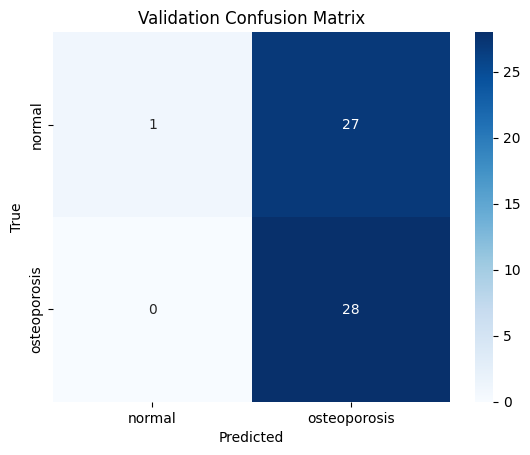


Test -> Accuracy: 0.5
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        28
osteoporosis       0.50      1.00      0.67        28

    accuracy                           0.50        56
   macro avg       0.25      0.50      0.33        56
weighted avg       0.25      0.50      0.33        56



C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jaina\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

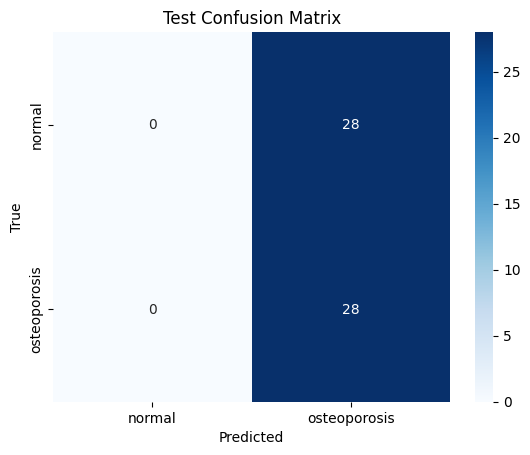


EVALUATION: PIPELINE 4 (Normalization Only)

Validation -> Accuracy: 0.6964285714285714
              precision    recall  f1-score   support

      normal       0.72      0.64      0.68        28
osteoporosis       0.68      0.75      0.71        28

    accuracy                           0.70        56
   macro avg       0.70      0.70      0.70        56
weighted avg       0.70      0.70      0.70        56



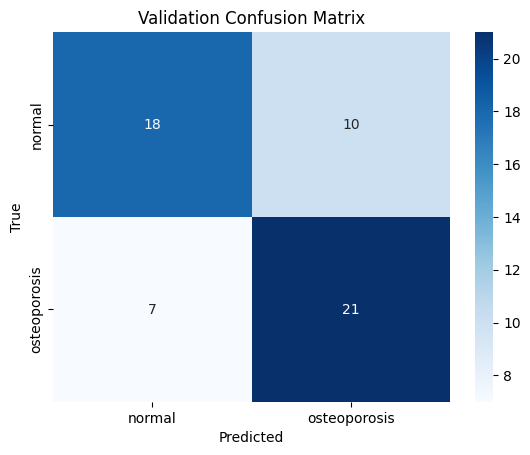


Test -> Accuracy: 0.6964285714285714
              precision    recall  f1-score   support

      normal       0.76      0.57      0.65        28
osteoporosis       0.66      0.82      0.73        28

    accuracy                           0.70        56
   macro avg       0.71      0.70      0.69        56
weighted avg       0.71      0.70      0.69        56



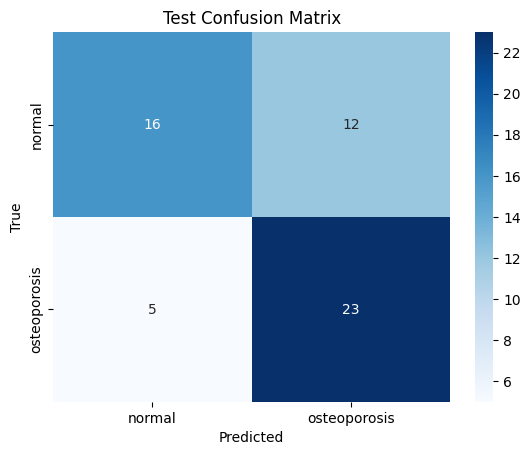


EVALUATION: PIPELINE 5 (Normalization Only)

Validation -> Accuracy: 0.7857142857142857
              precision    recall  f1-score   support

      normal       0.83      0.71      0.77        28
osteoporosis       0.75      0.86      0.80        28

    accuracy                           0.79        56
   macro avg       0.79      0.79      0.78        56
weighted avg       0.79      0.79      0.78        56



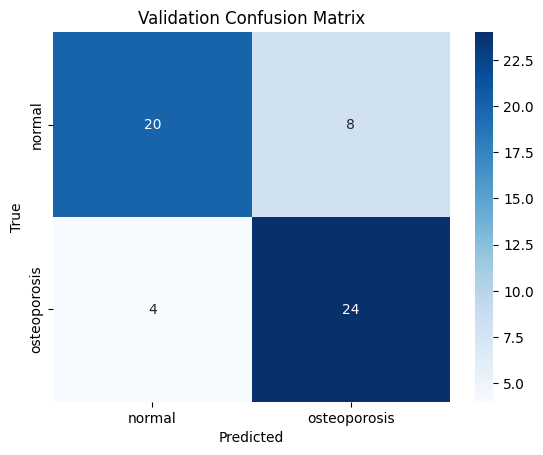


Test -> Accuracy: 0.6785714285714286
              precision    recall  f1-score   support

      normal       0.68      0.68      0.68        28
osteoporosis       0.68      0.68      0.68        28

    accuracy                           0.68        56
   macro avg       0.68      0.68      0.68        56
weighted avg       0.68      0.68      0.68        56



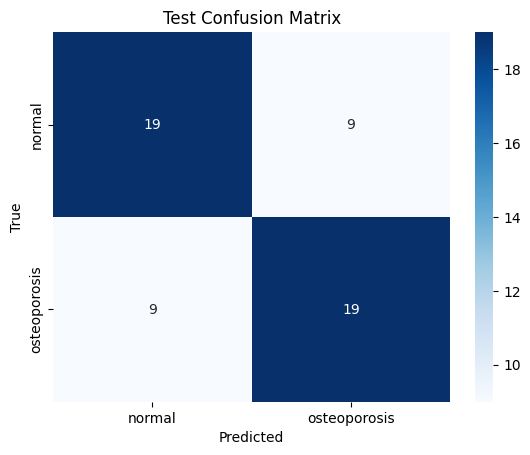

In [170]:
# ===============================
# 📌 Evaluate Both Pipelines
# ===============================
print("\nEVALUATION: PIPELINE 3 (Raw Images)")
evaluate_and_report(model_3, val_ds_3, "Validation")
evaluate_and_report(model_3, test_ds_3, "Test")

print("\nEVALUATION: PIPELINE 4 (Normalization Only)")
evaluate_and_report(model_4, val_ds_4, "Validation")
evaluate_and_report(model_4, test_ds_4, "Test")

print("\nEVALUATION: PIPELINE 5 (Normalization Only)")
evaluate_and_report(model_5, val_ds_5, "Validation")
evaluate_and_report(model_5, test_ds_5, "Test")

In [171]:
print("Total images:", len(all_image_paths))
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

# If you want to count batches from TF datasets:
train_count = sum(1 for _ in train_ds_3.unbatch())
val_count   = sum(1 for _ in val_ds_3.unbatch())
test_count  = sum(1 for _ in test_ds_3.unbatch())

print("\n=== Dataset Sizes After Augmentation Pipelines ===")
print(f"Train set size (after pipeline): {train_count}")
print(f"Val set size   (after pipeline): {val_count}")
print(f"Test set size  (after pipeline): {test_count}")


Total images: 372
Train: 260, Val: 56, Test: 56

=== Dataset Sizes After Augmentation Pipelines ===
Train set size (after pipeline): 260
Val set size   (after pipeline): 56
Test set size  (after pipeline): 56


In [173]:
# -----------------------------
# Pipeline 6: CLAHE + Augmentation + Dataset Expansion
# -----------------------------
def preprocess_6_img(path, label):
    """Preprocess: resize + CLAHE + normalization"""
    def _process(path_str):
        img = cv2.imread(path_str.decode(), cv2.IMREAD_COLOR)
        if img is None:
            img = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            img = cv2.resize(img, (224, 224))
            img = apply_clahe(img)
        img = img.astype("float32") / 255.0
        return img
    img = tf.numpy_function(_process, [path], tf.float32)
    img = tf.ensure_shape(img, (224, 224, 3))
    return img, label


def augment_image(img, label, num_aug=2):
    """Return dataset with original + num_aug augmented copies"""
    datasets = []

    # original
    datasets.append(tf.data.Dataset.from_tensors((img, label)))

    # augmented copies
    for _ in range(num_aug):
        aug_img = tf.image.random_flip_left_right(img)
        aug_img = tf.image.random_brightness(aug_img, max_delta=0.1)
        aug_img = tf.image.random_contrast(aug_img, 0.9, 1.1)
        datasets.append(tf.data.Dataset.from_tensors((aug_img, label)))

    # merge all datasets
    ds = datasets[0]
    for extra in datasets[1:]:
        ds = ds.concatenate(extra)

    return ds


def make_dataset_6(paths, labels, num_aug=2):
    """Build dataset for pipeline 6 with expansion"""
    base_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    base_ds = base_ds.map(preprocess_6_img, num_parallel_calls=AUTOTUNE)

    # expand dataset: each image → original + num_aug augmentations
    base_ds = base_ds.flat_map(lambda x, y: augment_image(x, y, num_aug))

    return base_ds.shuffle(512).batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Build datasets for Pipeline 6
train_ds_6 = make_dataset_6(train_paths, train_labels, num_aug=2)  # tripled
val_ds_6   = make_dataset_6(val_paths, val_labels, num_aug=0)      # no augmentation
test_ds_6  = make_dataset_6(test_paths, test_labels, num_aug=0)    # no augmentation


In [174]:
train_count_6 = sum(1 for _ in train_ds_6.unbatch())
val_count_6   = sum(1 for _ in val_ds_6.unbatch())
test_count_6  = sum(1 for _ in test_ds_6.unbatch())

print("\n=== Pipeline 6 Dataset Sizes (Expanded) ===")
print(f"Train set size: {train_count_6}")   # ~3× train_paths
print(f"Val set size  : {val_count_6}")     # same as val_paths
print(f"Test set size : {test_count_6}")    # same as test_paths



=== Pipeline 6 Dataset Sizes (Expanded) ===
Train set size: 780
Val set size  : 56
Test set size : 56


In [175]:
# Model
base_model_6 = tf.keras.applications.MobileNetV2(
    weights="imagenet", include_top=False, input_shape=(224,224,3)
)
base_model_6.trainable = False

model_6 = tf.keras.Sequential([
    base_model_6,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_6.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_6.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [176]:
print("\nTraining PIPELINE 1 (Raw Images)...\n")
history_6 = model_6.fit(train_ds_5, validation_data=val_ds_5, epochs=10)


Training PIPELINE 1 (Raw Images)...

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6077 - loss: 0.7218 - val_accuracy: 0.7679 - val_loss: 0.5547
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 863ms/step - accuracy: 0.6615 - loss: 0.6321 - val_accuracy: 0.7679 - val_loss: 0.5332
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 584ms/step - accuracy: 0.6923 - loss: 0.5802 - val_accuracy: 0.7857 - val_loss: 0.5216
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 573ms/step - accuracy: 0.6500 - loss: 0.6376 - val_accuracy: 0.7857 - val_loss: 0.5153
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 32s 922ms/step - accuracy: 0.6962 - loss: 0.6028 - val_accuracy: 0.7679 - val_loss: 0.5061
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 30s 541ms/step - accuracy: 0.6577 - loss: 0.6251 - val_accuracy: 0.7679 - val_loss: 0.5018
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - accuracy: 0.7077 - loss: 0.6099 - val_accuracy: 0.7500 - val_loss: 0.5107
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 502ms/step - accurac


EVALUATION: PIPELINE 6 (Normalization Only)

Validation -> Accuracy: 0.8035714285714286
              precision    recall  f1-score   support

      normal       0.90      0.68      0.78        28
osteoporosis       0.74      0.93      0.83        28

    accuracy                           0.80        56
   macro avg       0.82      0.80      0.80        56
weighted avg       0.82      0.80      0.80        56



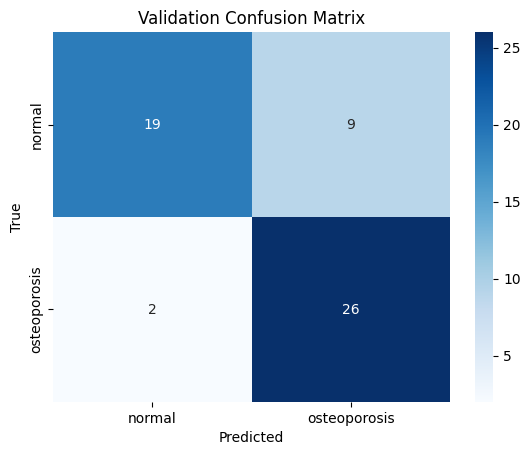


Test -> Accuracy: 0.8214285714285714
              precision    recall  f1-score   support

      normal       0.91      0.71      0.80        28
osteoporosis       0.76      0.93      0.84        28

    accuracy                           0.82        56
   macro avg       0.84      0.82      0.82        56
weighted avg       0.84      0.82      0.82        56



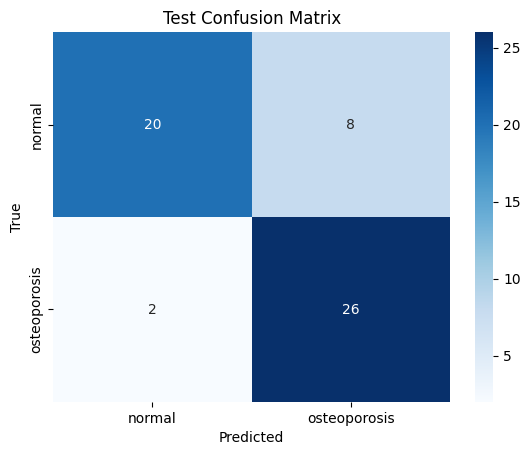

In [177]:
print("\nEVALUATION: PIPELINE 6 (Normalization Only)")
evaluate_and_report(model_6, val_ds_6, "Validation")
evaluate_and_report(model_6, test_ds_6, "Test")